Генератор данных, удаление шума, удаление периодического шума

Метрики: SSIM, MSE. Сравните изображения.

Изображения в оттенках серого.

# Задача 3.1

Выполните фильтрацию изображений при  помощи преобразования Фурье.

Сравните результаты фильтрации с алгоритмами, реализованными в task 1.

Sample 1:
--- Constant Noise ---
  Frequency Domain: SSIM = 0.0080, MSE = 22202.2246
  Spatial Domain:   SSIM = 0.9991, MSE = 0.0062
--- Gaussian Noise ---
  Frequency Domain: SSIM = 0.0078, MSE = 19857.5091
  Spatial Domain:   SSIM = 0.9991, MSE = 0.0077


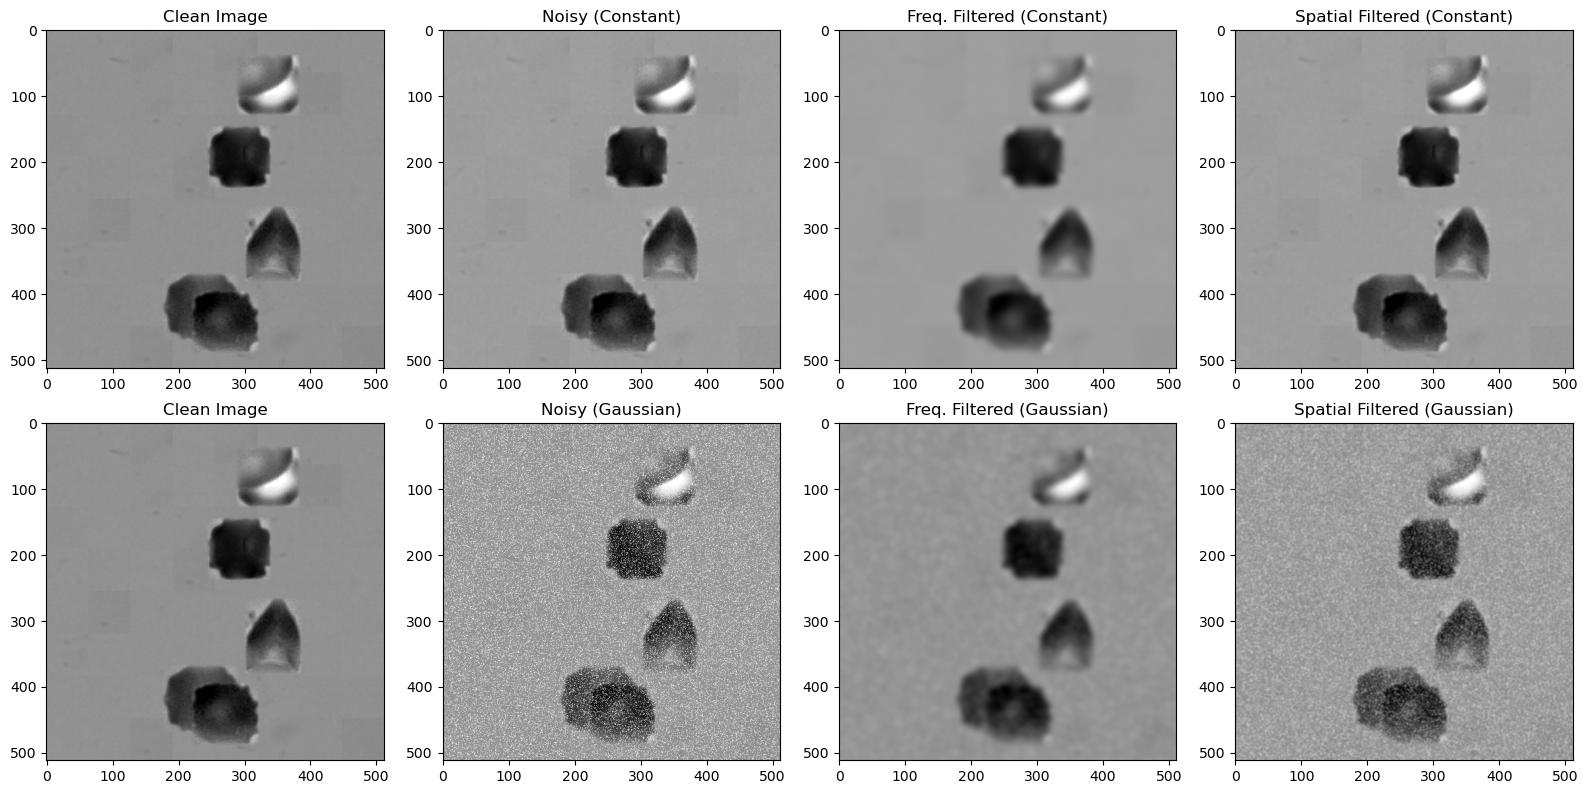

Sample 2:
--- Constant Noise ---
  Frequency Domain: SSIM = 0.0058, MSE = 51469.2011
  Spatial Domain:   SSIM = 0.9991, MSE = 0.0062
--- Gaussian Noise ---
  Frequency Domain: SSIM = 0.0046, MSE = 52036.2652
  Spatial Domain:   SSIM = 0.9991, MSE = 0.0072


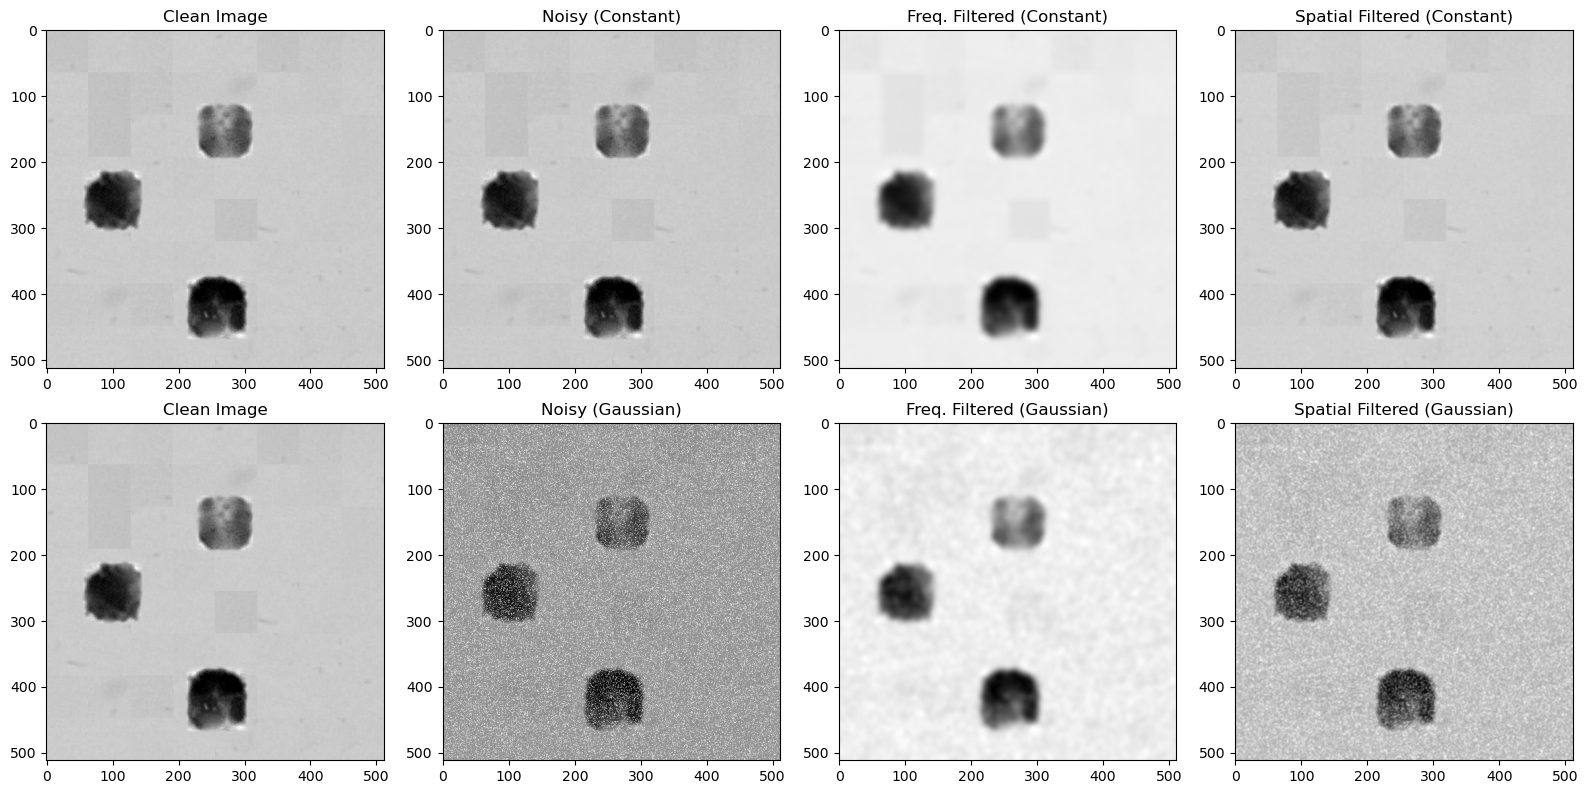

Sample 3:
--- Constant Noise ---
  Frequency Domain: SSIM = 0.0162, MSE = 25259.4230
  Spatial Domain:   SSIM = 0.9991, MSE = 0.0062
--- Gaussian Noise ---
  Frequency Domain: SSIM = 0.0062, MSE = 26780.5387
  Spatial Domain:   SSIM = 0.9989, MSE = 0.0088


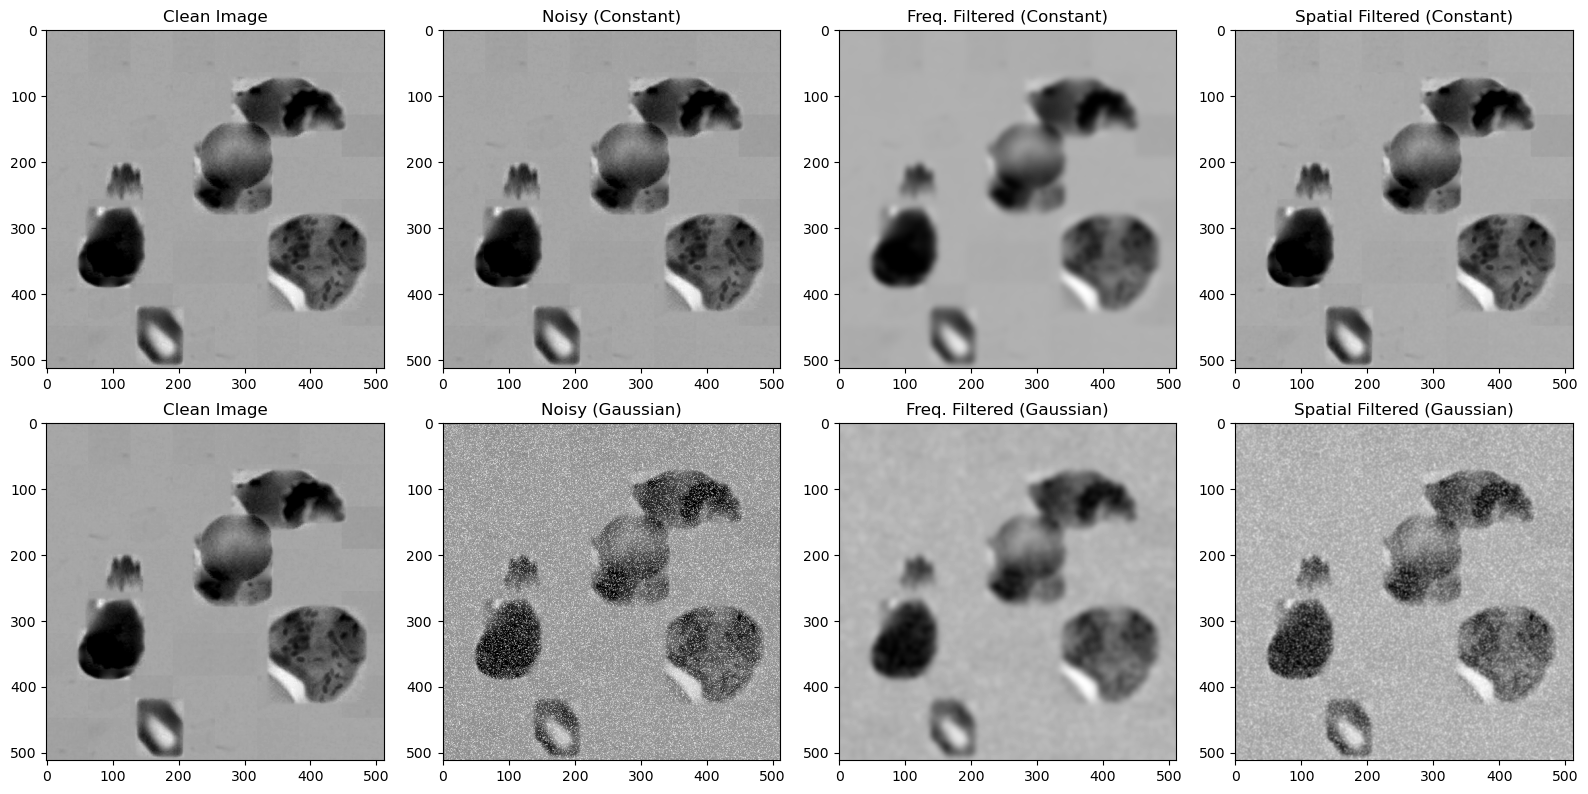

--- Average Metrics ---
--- Constant Noise ---
  Frequency Domain: SSIM = 0.0100, MSE = 32976.9496
  Spatial Domain:   SSIM = 0.9991, MSE = 0.0062
--- Gaussian Noise ---
  Frequency Domain: SSIM = 0.0062, MSE = 32891.4377
  Spatial Domain:   SSIM = 0.9990, MSE = 0.0079


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, metrics  
from scipy import ndimage
import os 

def apply_frequency_filter(image, filter_type="gaussian", radius=30, order=2, notch_coords=None):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.uint8)
    if filter_type == "ideal_lowpass":
        y, x = np.ogrid[:rows, :cols]
        distance = np.sqrt((x - ccol)**2 + (y - crow)**2)
        mask[distance > radius] = 0
    elif filter_type == "butterworth":
        y, x = np.ogrid[:rows, :cols]
        distance = np.sqrt((x - ccol)**2 + (y - crow)**2)
        mask = 1 / (1 + (distance / radius)**(2 * order))
    elif filter_type == "gaussian":
        y, x = np.ogrid[:rows, :cols]
        distance = np.sqrt((x - ccol)**2 + (y - crow)**2)
        mask = np.exp(-(distance ** 2) / (2 * radius ** 2))
    elif filter_type == "notch":
        if notch_coords is None:
            raise ValueError("Notch filter requires notch_coords (list of (x, y) tuples).")
        for x, y in notch_coords:
            mask[y - 10:y + 10, x - 10:x + 10] = 0  
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_back = (img_back - img_back.min()) / (img_back.max() - img_back.min())  
    img_back = np.uint8(img_back * 255)  
    return img_back

def apply_median_filter(image, size=3):
    return ndimage.median_filter(image, size=size)

def apply_gaussian_filter(image, sigma=1):
    return ndimage.gaussian_filter(image, sigma=sigma)

def calculate_metrics(image1, image2):
    ssim = metrics.structural_similarity(image1, image2, data_range=255)
    mse = metrics.mean_squared_error(image1, image2)
    return ssim, mse

base_dir = "."  
num_samples = 3 
clean_image_prefix = "clean_image_"
noisy_constant_prefix = "noisy_constant_image"
noisy_gaus_prefix = "noisy_gaus_image_"
image_extension = ".png"  
def load_image(filename):
    try:
        img = io.imread(filename, as_gray=True)  
        return img
    except FileNotFoundError:
        print(f"Error: File not found: {filename}")
        return None
filter_results = []
for i in range(0, num_samples):  
    clean_filename = os.path.join(base_dir, f"{clean_image_prefix}{i}{image_extension}")
    noisy_constant_filename = os.path.join(base_dir, f"{noisy_constant_prefix}{i}{image_extension}")
    noisy_gaus_filename = os.path.join(base_dir, f"{noisy_gaus_prefix}{i}{image_extension}")
    clean_image = load_image(clean_filename)
    noisy_constant_image = load_image(noisy_constant_filename)
    noisy_gaus_image = load_image(noisy_gaus_filename)
    if clean_image is None or noisy_constant_image is None or noisy_gaus_image is None:
        print(f"Skipping sample {i} due to missing image(s).")
        continue  
    filtered_image_constant_freq = apply_frequency_filter(noisy_constant_image, filter_type="gaussian", radius=20) 
    filtered_image_constant_spatial = apply_median_filter(noisy_constant_image, size=3) 
    ssim_constant_freq, mse_constant_freq = calculate_metrics(clean_image, filtered_image_constant_freq)
    ssim_constant_spatial, mse_constant_spatial = calculate_metrics(clean_image, filtered_image_constant_spatial)
    filtered_image_gaus_freq = apply_frequency_filter(noisy_gaus_image, filter_type="gaussian", radius=20)  
    filtered_image_gaus_spatial = apply_gaussian_filter(noisy_gaus_image, sigma=1)  
    ssim_gaus_freq, mse_gaus_freq = calculate_metrics(clean_image, filtered_image_gaus_freq)
    ssim_gaus_spatial, mse_gaus_spatial = calculate_metrics(clean_image, filtered_image_gaus_spatial)
    filter_results.append({
        "clean_image": clean_image,
        "noisy_constant_image": noisy_constant_image,
        "noisy_gaus_image": noisy_gaus_image,
        "filtered_image_constant_freq": filtered_image_constant_freq,
        "filtered_image_constant_spatial": filtered_image_constant_spatial,
        "filtered_image_gaus_freq": filtered_image_gaus_freq,
        "filtered_image_gaus_spatial": filtered_image_gaus_spatial,
        "ssim_constant_freq": ssim_constant_freq,
        "mse_constant_freq": mse_constant_freq,
        "ssim_constant_spatial": ssim_constant_spatial,
        "mse_constant_spatial": mse_constant_spatial,
        "ssim_gaus_freq": ssim_gaus_freq,
        "mse_gaus_freq": mse_gaus_freq,
        "ssim_gaus_spatial": ssim_gaus_spatial,
        "mse_gaus_spatial": mse_gaus_spatial,
    })
noise_types = ["constant", "gaussian"]
fd_ssim_values = {noise: [] for noise in noise_types}
fd_mse_values = {noise: [] for noise in noise_types}
sd_ssim_values = {noise: [] for noise in noise_types}
sd_mse_values = {noise: [] for noise in noise_types}
for i, results in enumerate(filter_results):
    print(f"Sample {i + 1}:")
    print("--- Constant Noise ---")
    print(f"  Frequency Domain: SSIM = {results['ssim_constant_freq']:.4f}, MSE = {results['mse_constant_freq']:.4f}")
    print(f"  Spatial Domain:   SSIM = {results['ssim_constant_spatial']:.4f}, MSE = {results['mse_constant_spatial']:.4f}")
    print("--- Gaussian Noise ---")
    print(f"  Frequency Domain: SSIM = {results['ssim_gaus_freq']:.4f}, MSE = {results['mse_gaus_freq']:.4f}")
    print(f"  Spatial Domain:   SSIM = {results['ssim_gaus_spatial']:.4f}, MSE = {results['mse_gaus_spatial']:.4f}")
    fd_ssim_values['constant'].append(results['ssim_constant_freq'])
    fd_mse_values['constant'].append(results['mse_constant_freq'])
    sd_ssim_values['constant'].append(results['ssim_constant_spatial'])
    sd_mse_values['constant'].append(results['mse_constant_spatial'])
    fd_ssim_values['gaussian'].append(results['ssim_gaus_freq'])
    fd_mse_values['gaussian'].append(results['mse_gaus_freq'])
    sd_ssim_values['gaussian'].append(results['ssim_gaus_spatial'])
    sd_mse_values['gaussian'].append(results['mse_gaus_spatial'])
    plt.figure(figsize=(16, 8))  
    plt.subplot(2, 4, 1)  
    plt.imshow(results["clean_image"], cmap='gray')
    plt.title('Clean Image')
    plt.subplot(2, 4, 2)  
    plt.imshow(results["noisy_constant_image"], cmap='gray')
    plt.title('Noisy (Constant)')
    plt.subplot(2, 4, 3)  
    plt.imshow(results["filtered_image_constant_freq"], cmap='gray')
    plt.title('Freq. Filtered (Constant)')
    plt.subplot(2, 4, 4)  
    plt.imshow(results["filtered_image_constant_spatial"], cmap='gray')
    plt.title('Spatial Filtered (Constant)')
    plt.subplot(2, 4, 5)  
    plt.imshow(results["clean_image"], cmap='gray')  
    plt.title('Clean Image')
    plt.subplot(2, 4, 6)  
    plt.imshow(results["noisy_gaus_image"], cmap='gray')
    plt.title('Noisy (Gaussian)')
    plt.subplot(2, 4, 7)  
    plt.imshow(results["filtered_image_gaus_freq"], cmap='gray')
    plt.title('Freq. Filtered (Gaussian)')
    plt.subplot(2, 4, 8)  
    plt.imshow(results["filtered_image_gaus_spatial"], cmap='gray')
    plt.title('Spatial Filtered (Gaussian)')
    plt.tight_layout()
    plt.show()
print("--- Average Metrics ---")
for noise_type in noise_types:
    print(f"--- {noise_type.capitalize()} Noise ---")
    print(f"  Frequency Domain: SSIM = {np.mean(fd_ssim_values[noise_type]):.4f}, MSE = {np.mean(fd_mse_values[noise_type]):.4f}")
    print(f"  Spatial Domain:   SSIM = {np.mean(sd_ssim_values[noise_type]):.4f}, MSE = {np.mean(sd_mse_values[noise_type]):.4f}")
    

# Задача 3.2 

Обновите генератор, который Вы создали в task_1.

Добавьте деградационный периодический шум (покомпонентноее умножение исходного и зашумленного изображения).

Выполните фильтрацию периодического шума при  помощи преобразования Фурье. 

Оцените качество фильтрации.

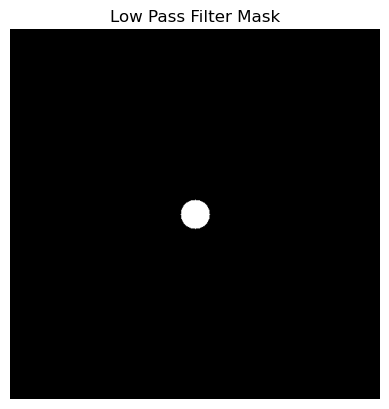

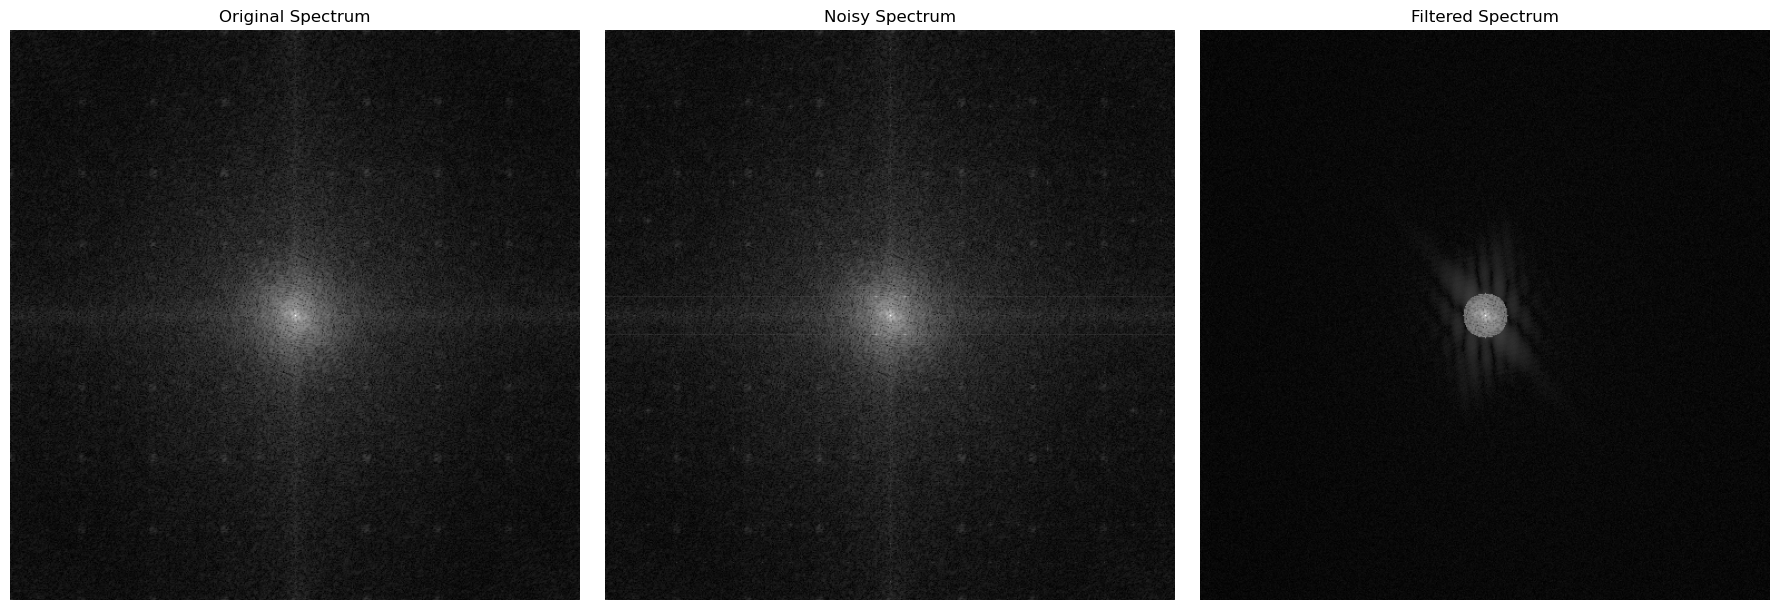

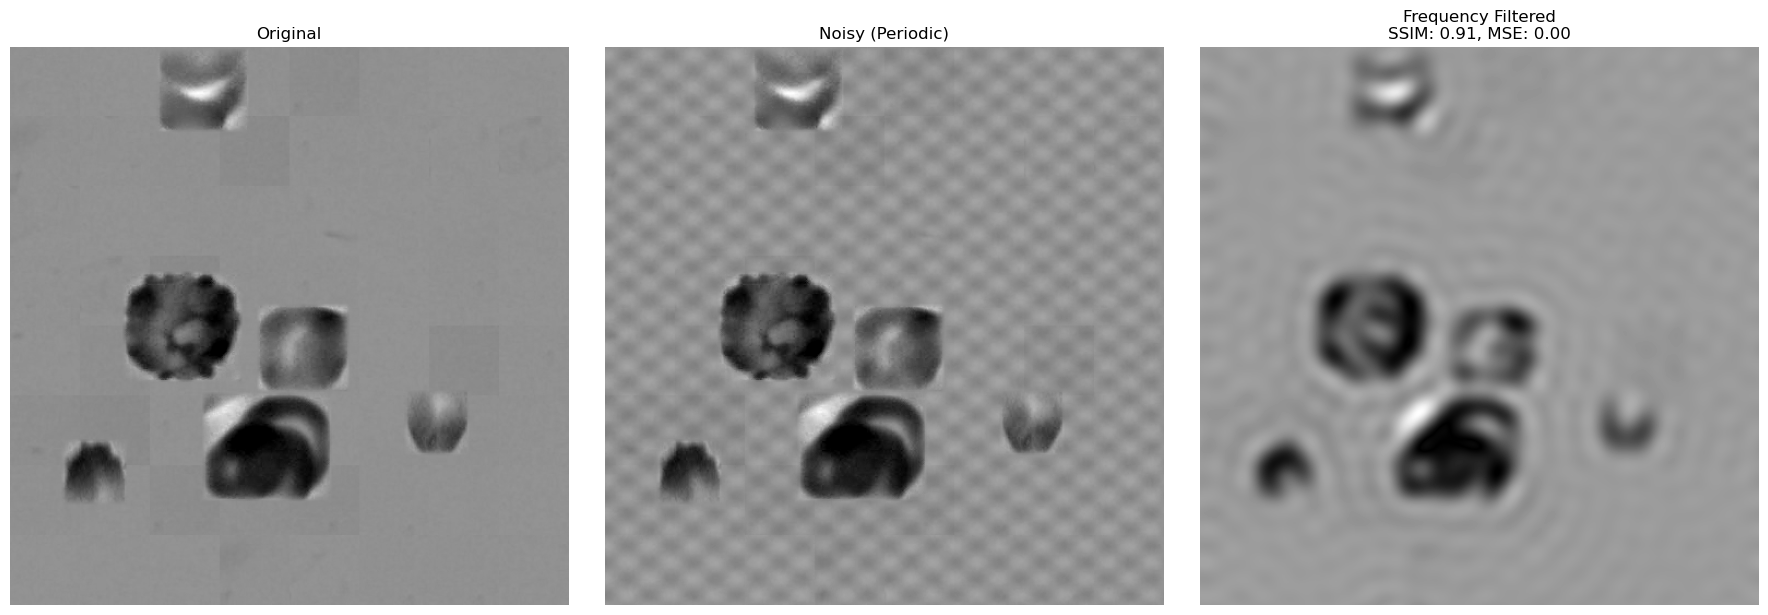

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage import img_as_float


config = {
    "noise_amplitude": 0.1,  
    "noise_frequency": (30, 40),  
    "low_pass_radius": 20,  
    "image_path": "clean_image_0.png", 
    "image_size": (512, 512),  
}

def add_periodic_noise(image, amplitude=0.1, frequency=(30, 40)):
    rows, cols = image.shape
    noise = np.zeros((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            noise[i, j] = amplitude * np.sin(2 * np.pi * i / frequency[0]) * np.cos(2 * np.pi * j / frequency[1])
    image_float = image.astype(np.float32) / 255.0
    noisy_image = image_float * (1 + noise)
    noisy_image = np.clip(noisy_image, 0, 1)
    return (noisy_image * 255).astype(np.uint8)

def apply_low_pass_filter(image, radius=50):
    image_float = img_as_float(image)
    f = np.fft.fft2(image_float)
    fshift = np.fft.fftshift(f)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    cv2.circle(mask, (ccol, crow), radius, 1, -1)
    plt.imshow(mask, cmap='gray')
    plt.title("Low Pass Filter Mask")
    plt.axis('off')
    plt.show()
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_back = (img_back - img_back.min()) / (img_back.max() - img_back.min())
    return (img_back * 255).astype(np.uint8)

def calculate_metrics(original, filtered):
    original_float = img_as_float(original)
    filtered_float = img_as_float(filtered)
    ssim_value = ssim(original_float, filtered_float, data_range=1.0)
    mse_value = mse(original_float, filtered_float)
    return ssim_value, mse_value

def visualize_spectrum(image, title):
    image_float = img_as_float(image)
    f = np.fft.fft2(image_float)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)
    magnitude_spectrum = (magnitude_spectrum - np.min(magnitude_spectrum)) / (np.max(magnitude_spectrum) - np.min(magnitude_spectrum) + 1e-8)
    magnitude_spectrum = np.clip(magnitude_spectrum, 0, 1)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(title)
    plt.axis('off')

original_image = cv2.imread(config["image_path"], cv2.IMREAD_GRAYSCALE)
original_image = cv2.resize(original_image, config["image_size"])
if original_image is None:
    print(f"Ошибка загрузки изображения из {config['image_path']}")
    exit()
noisy_periodic_image = add_periodic_noise(
    original_image.copy(),
    amplitude=config["noise_amplitude"],
    frequency=config["noise_frequency"]
)
fd_filtered_image = apply_low_pass_filter(
    noisy_periodic_image,
    radius=config["low_pass_radius"]
)
fig_spectra, axes_spectra = plt.subplots(1, 3, figsize=(18, 6))
plt.sca(axes_spectra[0])
visualize_spectrum(original_image, "Original Spectrum")
plt.sca(axes_spectra[1])
visualize_spectrum(noisy_periodic_image, "Noisy Spectrum")
plt.sca(axes_spectra[2])
visualize_spectrum(fd_filtered_image, "Filtered Spectrum")
plt.tight_layout()
plt.show()
fd_ssim, fd_mse = calculate_metrics(original_image, fd_filtered_image)
fig_images, axes_images = plt.subplots(1, 3, figsize=(18, 6))
axes_images[0].imshow(original_image, cmap='gray')
axes_images[0].set_title("Original")
axes_images[0].axis('off')
axes_images[1].imshow(noisy_periodic_image, cmap='gray')
axes_images[1].set_title("Noisy (Periodic)")
axes_images[1].axis('off')
axes_images[2].imshow(fd_filtered_image, cmap='gray')
axes_images[2].set_title(f"Frequency Filtered\nSSIM: {fd_ssim:.2f}, MSE: {fd_mse:.2f}")
axes_images[2].axis('off')
plt.tight_layout()
plt.show()